In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd 'drive/My Drive/Development/Biometrics/face'

/content/drive/My Drive/Development/Biometrics/face


In [4]:
import sys
print("Python version :", sys.version)
import numpy as np
import cv2
from pathlib import Path
import pickle # exporting intermediate data to disk
from tqdm.notebook import tqdm as tqdm_notebook # Visual progress bar
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline
import imutils # handy routines for image manipulation (from Adrian Rosenbrock)
import seaborn as sns
import os.path
sns.set(style="dark")
from IPython.core.display import HTML
from IPython.display import clear_output
def center_plots(horizontal=False):
  display(HTML("""
  <style>
  #output-body {
    display: flex;
    flex-direction: """ + ('row' if horizontal else 'column') + """;
    align-items: center;
    justify-content: center;
  }
  </style>
  """))
import importlib

Python version : 3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Read Dataset

In [5]:
face_size=(47, 47) # size of each face after preprocessing

In [6]:
import pandas as pd

def read_img(imagePath):
    img = cv2.imread(str(imagePath), cv2.IMREAD_COLOR) # cv2.IMREAD_GRAYSCALE
    # ROI (region of interest), and resize it to a canonical size
    imagePathStem = str(imagePath.stem)
    k = int(imagePathStem[imagePathStem.rfind("_") + 1:][:4]) - 1
    return img, imagePath.parent.name
     
# Grab in all the subdirs all the image paths associated with the faces
datasetPath = Path("CalTechFacesDirs")
imagePaths = list(datasetPath.glob("*/*.jpg"))

# Read image and label information
read_images_path = './pickle/caltech.p'
if os.path.isfile(read_images_path):
  saved_pickle_file = open(read_images_path, 'rb')
  (data,data_color) = pickle.load(saved_pickle_file)
else:
  imgs = [read_img(imagePath) for imagePath in tqdm_notebook(imagePaths)]
  data_color = pd.DataFrame(imgs, columns =['images', 'target']).to_dict('list')
  gray_imgs = [(cv2.cvtColor(i,cv2.COLOR_BGR2GRAY),p) for (i,p) in imgs]
  data = pd.DataFrame(gray_imgs, columns =['images', 'target']).to_dict('list')
  tosave_pickle_file = open(read_images_path, 'wb')
  pickle.dump((data,data_color), tosave_pickle_file)

# Check if all images were found successfully (5 images were removed from the original set)
assert len(data['images']) == len(data['target']) == 445

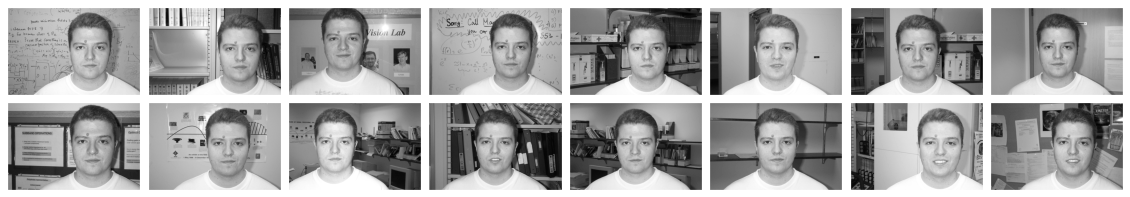

In [7]:
# Inspect images
center_plots()
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 8), axes_pad=0.1)
for ax, im, label in zip(grid, data['images'], data['target']):
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Detecting faces

Even though the bounding box coordinates are stored in the <em>CalTechFacesDirs/ImageData.mat</em> file, we'll be computing them from scratch for demonstrative purposes. 

*First I make a generic interface for face detection strategies to make the code more extensible.*


In [8]:
from abc import ABC, abstractmethod 
from sklearn.datasets.base import Bunch
from sklearn.preprocessing import LabelEncoder
import re

class FaceDetectionStrategy(ABC): 
  """Abstract class for face detection strategies."""
  def __init__(self, name=""):
    self.name = name
  def detect(self, image, minsize): # returns [(x,y,w,h),...]
    pass
  def detect_multi(self, images, labels, minsize=(30,30), paths=None, verbose=True, take_largest=True):
    feat_data, face_images, face_labels, not_detected, all_faces, indices, original_indices = [], [], [], [], [], [], []
    for idx in tqdm_notebook(range(len(images))):
      image = images[idx]
      label = labels[idx]
      faces = self.detect(image, minsize)
      if take_largest and len(faces) > 1:
        faces = [faces[np.argmax([w*h for (x,y,w,h) in faces])]]
      if paths is not None and len(faces) != 1: # assumption that each image has just one face to detect
        path = paths[idx]
        if verbose:
          print('Did not find exactly one face in image at path : ', path, ' (# detected faces = ', len(faces), ')')
        not_detected.append(image) # unused for the moment
      if len(faces) > 0:
        all_faces.append(faces[np.argmax([w*h for (x,y,w,h) in faces])])
        indices.append(int(re.findall('\d*\.?\d+', paths[idx].stem)[0]))
        original_indices.append(idx)
      for (x, y, w, h) in faces: # iterate faces found in image
        new_img = image.copy()
        raw_face = new_img[y:y+h, x:x+w] # extract ROI
        face = cv2.resize(raw_face, face_size) # resize the face to the preferred size
        face_flatten = face.flatten()
        face_images.append(np.expand_dims(face, axis=-1)), feat_data.append(face_flatten), face_labels.append(label)
    label_encoder = LabelEncoder()
    targets = label_encoder.fit_transform(face_labels)
    return Bunch( data       = np.array(feat_data), 
                  images     = np.array(face_images), 
                  labels     = np.array(face_labels),
                  target     = np.array(targets),
                  boxes      = np.array(all_faces),
                  indices    = np.array(indices),
                  original_indices = np.array(original_indices))

class FaceDetectionHaar(FaceDetectionStrategy):
  """A class for detecting faces using Haar features (Viola-Jones detector)."""
  def __init__(self):
    super().__init__("Viola-Jones")
    self.faceCascade = cv2.CascadeClassifier('./models/haarcascade_frontalface_default.xml')
  def detect(self, image, minsize):
    return self.faceCascade.detectMultiScale(
        image,
        scaleFactor = 1.2,
        minNeighbors = 9,
        minSize = minsize,
        flags = cv2.CASCADE_SCALE_IMAGE
    )

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


*In the original code, there were some artifacts, and some pictures where no faces were detected. Increasing the minimum size of faces is one way to deal with this but turned out not to work (plus, it might cause problems in other data sets with smaller input images which in a sense would be a case of overfitting). Instead I allow one to set a flag such that, when multiple faces are found, the largest one is the only one that's selected.*

*A detector which could discriminate between real faces and these artifacts would be ideal, but it seems like a very hard problem. Alternatively, the .mat file could be used.*

In [9]:
# Detect faces with Viola-Jones detector and save to disk
detection_strategy = FaceDetectionHaar()
faces_path = './pickle/caltech_faces.p'
if os.path.isfile(faces_path):
  saved_pickle_file = open(faces_path, 'rb')
  faces = pickle.load(saved_pickle_file)
else:
  faces = detection_strategy.detect_multi(data['images'], data['target'], paths=imagePaths, take_largest=True)
  tosave_pickle_file = open(faces_path, 'wb')
  pickle.dump(faces, tosave_pickle_file)

*Note that some faces couldn't be extracted with this detector (10 in total).*

In [10]:
# Extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = faces.images.shape
imshape = (h, w, n_channels)

# Count number of individuals
n_classes = faces.target.max() +1
n_features = faces.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)

Total dataset size:
n_samples: 435
n_classes: 26
n_features: 2209


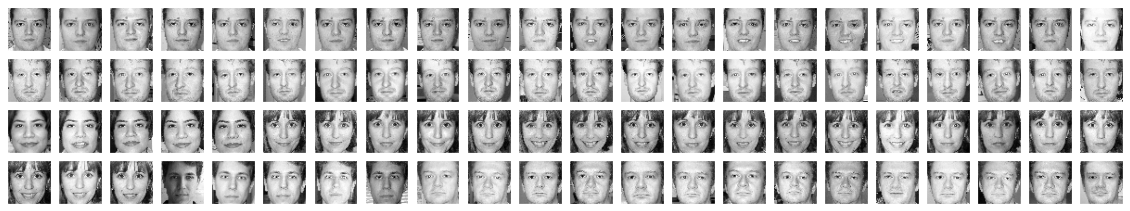

In [11]:
# Visualise some detected faces
center_plots()
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 22), axes_pad=0.1)
for ax, im, t in zip(grid, faces['images'], faces['target']):
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

*I visualise the class distribution next, as any class imbalance should be accounted for (it will matter a lot when using stratification and upon using technologies like SVMs).*

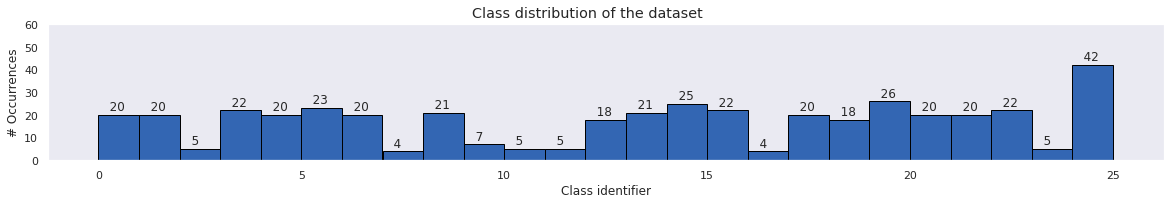

In [12]:
# Visualise class distribution
center_plots()
figure, axes = plt.subplots(figsize=(20,2.5))
figure.suptitle('Class distribution of the dataset') 
nb_bins = max(faces.target)
histogram = axes.hist(faces.target, color=(0.2,0.4,0.7), edgecolor='black', histtype='bar', bins=nb_bins)
for i in range(nb_bins):
  plt.text(histogram[1][i], histogram[0][i]+2, "   " + str(int(histogram[0][i])))
axes.set(xlabel='Class identifier')  
axes.set(ylabel='# Occurrences')  
axes.set(ylim=[0.0,60.0])
plt.show()

### Feature Extraction

Images tend to be large and can differ a lot in lighting, positioning, ... To combat this we'll extract features from each image using 4 different techniques. They all belong to the global/holistic feature representation approaches that map the image to a lower-dimensional subspace through linear and non-linear mapping. 

In [23]:
from abc import ABC, abstractmethod 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

"""
A class of strategies for recognizing faces in images.
The constructor takes a dataset split in a training and test set.
Every strategy can be fitted, can be used to generate embeddings, distances
  between embeddings.
The methods returning scores can be used for validation / evaluation.
"""
class FaceRecognitionStrategy(ABC): 
  def __init__(self, x_train, y_train, x_test, y_test, name=""):
    self.x_train = x_train
    self.x_test = x_test
    self.y_train = y_train
    self.y_test = y_test
    #self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(x_rest, y_rest, test_size=(1/3), shuffle=True, stratify=y_rest, random_state=22) # for reproducibility
    self.name = name
    self.embeddings = None
  def fit(self): # train model on data (possibly supervised)
    pass
  def describe(self, images): # calculate vector embeddings for images
    pass
  def distance(self, embedding_1, embedding_2): # calculate distance between two embeddings
    pass
  def accuracy(self, classifier=KNeighborsClassifier(n_neighbors=1, metric='euclidean')):
    if self.embeddings is None:
      self.embeddings = self.describe(self.x_train)
    embeddings_test = self.describe(self.x_test)
    classifier.fit(self.embeddings, self.y_train)
    return accuracy_score(self.y_test, classifier.predict(embeddings_test))
  def __get_scores(self, input_set=None, input_labels=None):
    """Set 2 is compared to set 1 and the distances and similarity matrix are returned."""
    if self.embeddings is None:
      self.embeddings = self.describe(self.x_train)
    if input_set is None:
      input_labels = self.y_train
    embeddings_test = self.embeddings if input_set is None else self.describe(input_set)
    size, size_test = len(self.embeddings), len(embeddings_test)
    uniques = sorted(list(set(self.y_train)))
    matrix = [[[] for j in range(len(uniques))] for i in range(len(uniques))]
    for i in range(size):
      for j in range(i+1 if input_set is None else 0, size_test):
        dist = self.distance(self.embeddings[i], embeddings_test[j])
        matrix[uniques.index(self.y_train[i])][uniques.index(input_labels[j])].append(dist)
        if self.y_train[i] != input_labels[j]:
          matrix[uniques.index(input_labels[j])][uniques.index(self.y_train[i])].append(dist)
    distances = np.asarray([self.distance(embeddings_test[i],embeddings_test[j]) for i in range(size_test) for j in range(size_test) if i < j])
    genuine_id = np.asarray([1 if input_labels[i] == input_labels[j] else 0 for i in range(size_test) for j in range(size_test) if i < j])
    minimum, delta = min(distances), (max(distances) - min(distances))
    distances_normalised = (distances - minimum) / delta
    matrix = 1 - (np.vectorize(np.mean)(matrix) - minimum) / delta
    return genuine_id, distances, distances_normalised, matrix
  def get_scores(self):
    return self.__get_scores()
  def get_scores_test(self):
    return self.__get_scores(self.x_test, self.y_test)
  def tune(self):
    pass

class DimensionalityReduction(FaceRecognitionStrategy):
  def __init__(self, x_train, y_train, x_test, y_test, name, nb_components=25):
    super().__init__(x_train, y_train, x_test, y_test, name)
    self.nb_components = min(nb_components, min(len(self.x_train), len(self.x_train[0].flatten())))

#### LBP for face recognition

In [24]:
from localmodules.local_binary_patterns import LBP
#from scipy.stats import chisquare

class LBPStrategy(FaceRecognitionStrategy):
  def __init__(self, x_train, y_train, x_test, y_test):
    super().__init__(x_train, y_train, x_test, y_test, "LBP")
  def fit(self):
    self.descriptor = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
  def describe(self, images):
    return self.descriptor.describe_list(images[...,0])
  def distance(self, embedding_1, embedding_2):
    return cv2.compareHist(np.float32(embedding_1), np.float32(embedding_2), cv2.HISTCMP_CHISQR)

#### Eigenfaces for face recognition

In [25]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

class PCAStrategy(DimensionalityReduction):
  def __init__(self, x_train, y_train, x_test, y_test):
    super().__init__(x_train, y_train, x_test, y_test, "PCA")
  def fit(self):
    data = np.array([image.flatten() for image in self.x_train])
    self.descriptor = PCA(n_components=self.nb_components, svd_solver='full', whiten=True).fit(data) # randomized SVD not reproducable
  def describe(self, images):
    image_features = np.array([image.flatten() for image in images]) # just the images, flattened
    return self.descriptor.transform(image_features)
  def distance(self, embedding_1, embedding_2):
    return euclidean(embedding_1, embedding_2)

#### Fisherfaces for face recognition

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial.distance import euclidean

class LDAStrategy(DimensionalityReduction):
  def __init__(self, x_train, y_train, x_test, y_test):
    super().__init__(x_train, y_train, x_test, y_test, "LDA")
  def fit(self):
    train_set = np.array([image.flatten() for image in self.x_train])
    self.descriptor = LinearDiscriminantAnalysis(n_components=self.nb_components).fit(train_set, self.y_train)
  def describe(self, images):
    image_set = np.array([image.flatten() for image in images])
    return self.descriptor.transform(image_set)
  def distance(self, embedding_1, embedding_2):
    return euclidean(embedding_1, embedding_2)

#### Deep metric learning

##### Deep Metric Learning using Siamese Networks

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          894400      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0           sequential_2[1][0]         

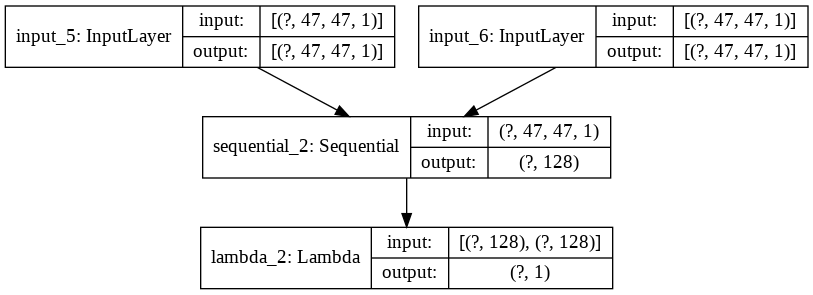

In [27]:
import localmodules.siamese as siamese
from tensorflow.keras.utils import plot_model
center_plots()
encoder, model = siamese.create_siamese_model(imshape)
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [28]:
from tensorflow.keras.optimizers import RMSprop, Adam
from scipy.spatial.distance import euclidean
import localmodules.siamese as siamese
from sklearn.metrics import accuracy_score

class SiameseNetworkStrategy(FaceRecognitionStrategy):
  def __init__(self, x_train, y_train, x_test, y_test):
    super().__init__(x_train, y_train, x_test, y_test, "(D)NN")
    _, data_h, data_w, data_channels = x_train.shape
    self.encoder, self.model = siamese.create_siamese_model((data_h, data_w, data_channels))
  def fit(self, rms=Adam(), epochs=20):
    x_train_pairs, y_train_pairs = siamese.get_siamese_paired_data(self.x_train, self.y_train)
    self.model.compile(
        loss=siamese.contrastive_loss, 
        optimizer=rms, 
        metrics = [siamese.accuracy])
    self.model.fit([x_train_pairs[:, 0], x_train_pairs[:, 1]], y_train_pairs, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
  def describe(self, images):
    return self.encoder(images.astype(float)).numpy()
  def distance(self, embedding_1, embedding_2):
    return cv2.compareHist(np.float32(embedding_1), np.float32(embedding_2), cv2.HISTCMP_CHISQR)
  def accuracy(self):
    x_test_pairs, y_test_pairs = siamese.get_siamese_paired_data(self.x_test, self.y_test)
    test_scores = self.model.predict([x_test_pairs[:, 0], x_test_pairs[:, 1]])
    return accuracy_score(y_test_pairs, test_scores > 0.5)

*I split the data in a training and test set to do training and then evaluation separately. I'm used to simply have a training set which might or might not be split into a training + validation set for training and tuning purposes (the validation set is used to tune hyperparameters as it gives an idea of generalisation), after which the test set is used for evaluation, i.e. gauging the efficacy of a system (or comparing some of them.*

*I do this split beforehand to be able to compare the various systems in a fair way. Normally what would happen is to pick a threshold later on through cross-validation and then check metrics on the test set, but in this notebook I will generally just calculate ROC - and other curves for the test set and compare systems that way.*

In [29]:
def split_data(data, test_size=.25):
  """Split the given data in a training and a test set."""
  if len(data.images.shape) == 3:
    data.images = np.expand_dims(data.images, 3)
  return train_test_split(data.images, data.target, test_size=test_size, 
                          shuffle=True, stratify=data.target, 
                          random_state=22) # for reproducibility
x_train, x_test, y_train, y_test = split_data(faces)
print(x_train.shape, x_test.shape)

(326, 47, 47, 1) (109, 47, 47, 1)


*One can opt for any of the 4 strategies next. First the model is fitted on the training data, then the accuracy is measured (on the test set). The accuracy is determined with KNN except for the siamese neural network.*

In [30]:
# Train model and calculate accuracy (default classifier is kNN, k=1)
strategy = PCAStrategy(x_train, y_train, x_test, y_test)
strategy.fit()
print("Accuracy on the test set: {}".format(strategy.accuracy()))

Accuracy on the test set: 0.8899082568807339


### Classification in typical biometrics setting

In [35]:
# Train using all but the DNN strategies and calculate accuracy (default classifier is kNN, k=1)
# DNN performance is determined later, but I didn't want to train for long just for an initial estimate
# It's better than LDA
strategy_classes = [LBPStrategy, PCAStrategy, LDAStrategy, SiameseNetworkStrategy]
strategies = [strategy(x_train, y_train, x_test, y_test) for strategy in strategy_classes]
for strategy in strategies[:-1]:
  strategy.fit()
  print("Accuracy on the test set: {}".format(strategy.accuracy()))

Accuracy on the test set: 0.8348623853211009
Accuracy on the test set: 0.8899082568807339
Accuracy on the test set: 0.9541284403669725


#### Task 1: Compute pair-wise matching scores


*I consider all strategies here and determine similarity scores for pairs of samples taken from the validation - or the test set. The resulting distances, normalised distances and similarity matrices are stored on disk.*

In [36]:
import os.path

"""
This block of code finds scores i.e. distances & similarity matrices for the
train and the test set then stores them on disk.
  The training set result is used for validation.
  The test set scores are used for evaluation.
"""
recompute = False # set to true if starting from scratch
scores_dict = {} # holds the distances & similarity matrices for training set
scores_test_dict = {} # holds the distances & similarities for the test set for the evaluation at the end
for strategy in strategies:
  scores_file = './scores/scores_' + strategy.name + '.p'
  scores_test_file = './scores/scores_test_' + strategy.name + '.p'
  has_scores = os.path.isfile(scores_file)
  has_test_scores = os.path.isfile(scores_test_file)
  if recompute or not(has_scores) or not(has_test_scores): # check if the scores have to be recomputed
    strategy.fit() # if yes the model has to be fitted first
  if recompute or not(has_scores): # recompute training set scores
    (genuine_id, distances, normalised, matrix) = strategy.get_scores()
    pickle_file = open(scores_file, "wb")
    pickle.dump((genuine_id, distances, normalised, matrix), pickle_file)
  else: # load training set scores from disk
    pickle_file = open(scores_file, "rb")
    (genuine_id, distances, normalised, matrix) = pickle.load(pickle_file)
  if recompute or not(has_test_scores): # recompute test set scores
    (genuine_id_test, distances_test, normalised_test, matrix_test) = strategy.get_scores_test()
    pickle_file_test = open(scores_test_file, "wb")
    pickle.dump((genuine_id_test, distances_test, normalised_test, matrix_test), pickle_file_test)
  else: # load test set score from disk
    pickle_file_test = open(scores_test_file, "rb")
    (genuine_id_test, distances_test, normalised_test, matrix_test) = pickle.load(pickle_file_test)
  scores_dict[strategy.name] = (genuine_id, distances, normalised, matrix)
  scores_test_dict[strategy.name] = (genuine_id_test, distances_test, normalised_test, matrix_test)
  print('Number of scores ('+ strategy.name + ') = ', distances.shape[0])
  print('Number of test scores ('+ strategy.name + ') = ', distances_test.shape[0])

Number of scores (LBP) =  52975
Number of test scores (LBP) =  5886
Number of scores (PCA) =  52975
Number of test scores (PCA) =  5886
Number of scores (LDA) =  52975
Number of test scores (LDA) =  5886
Epoch 1/20
50/50 - 24s - loss: 0.0613 - accuracy: 0.8400 - val_loss: 0.0387 - val_accuracy: 0.9111
Epoch 2/20
50/50 - 24s - loss: 0.0203 - accuracy: 0.9781 - val_loss: 0.0150 - val_accuracy: 0.9736
Epoch 3/20
50/50 - 27s - loss: 0.0121 - accuracy: 0.9925 - val_loss: 0.0114 - val_accuracy: 0.9832
Epoch 4/20
50/50 - 23s - loss: 0.0083 - accuracy: 0.9956 - val_loss: 0.0089 - val_accuracy: 0.9832
Epoch 5/20
50/50 - 23s - loss: 0.0059 - accuracy: 0.9987 - val_loss: 0.0073 - val_accuracy: 0.9904
Epoch 6/20
50/50 - 24s - loss: 0.0043 - accuracy: 0.9994 - val_loss: 0.0067 - val_accuracy: 0.9928
Epoch 7/20
50/50 - 23s - loss: 0.0039 - accuracy: 0.9994 - val_loss: 0.0051 - val_accuracy: 0.9952
Epoch 8/20
50/50 - 23s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 0.9952
Epoc

### Advanced Classification Scenario
Biometrics classification is based on generating pairwise matching scores. 
* In verification mode one compares this matching score to a decision threshold in a 1-to-1 classification setting.
* In identifcation mode one uses this matching score to rank the templates in the database and, possibly, thresholding it as well in a 1-to-N classification setting

Hence, a simple pairwise comparision (L2-distance, e.g.) can be used. 

In a more general classification scenario one can use the feature representations to build more complex classifiers (SVM, NN, etc.). Testing then requires a splitting in training and validation subsets. 

In [37]:
# Measure accuracy on test set with 2 different types of classifiers
from sklearn.svm import SVC
strategy = LDAStrategy(x_train, y_train, x_test, y_test)
strategy.fit()
for i in [1,2,3,5]:
  knn_accuracy = strategy.accuracy(classifier=KNeighborsClassifier(n_neighbors=i, metric='euclidean'))
  print(f'kNN (k = {i}) accuracy = {knn_accuracy}')
svm_accuracy = strategy.accuracy(classifier=SVC(C=10.0, gamma=0.01))
print(f'SVM accuracy = {svm_accuracy}')

kNN (k = 1) accuracy = 0.9541284403669725
kNN (k = 2) accuracy = 0.926605504587156
kNN (k = 3) accuracy = 0.9541284403669725
kNN (k = 5) accuracy = 0.9724770642201835
SVM accuracy = 0.963302752293578


*A few comments for now. I refactored the code such that each strategy is represented by a class. Each of these classes start by constructing a training and test set. The training set has 75% of the data, the remaining sets each have 25%. I used a set amount of components for PCA and LDA which could be seen as manual tuning, but there are better ways to do this (eg. Minka's MLE which admittedly can't be used on this dataset as there are too little samples.*

*It was instructed to do validation based on the embeddings and related scores. Now, the embeddings are those of the training set. For something like LBP this is fine, but for the siamese network (for example) it means you might get much better scores on the training part of the set (it does use a random split for validation while training but 80% is the training set) but the question then is to what extent this is due to overfitting. So initial estimates of performance might be a bit optimistic.*

### Evaluation

#### Validation as verification system

#### Task 2: Compute F1 and accuracy scores for variable (and optimal) thresholds

* Calculate and plot F1 and accuracy scores for a range (min, max) of thresholds.
* Determine some optimal threshold (look up in classification literature)

Max F1 score at threshold = 0.878788 (LBP).
Accuracy at this threshold = 0.944729.
FPR at this threshold = 0.031846.
FRR at this threshold = 0.580460.
Max Fß score at threshold = 0.838384 (LBP).
Accuracy at this threshold = 0.821369.
FPR at this threshold = 0.172914.
FRR at this threshold = 0.306808.
---
Max F1 score at threshold = 0.747475 (PCA).
Accuracy at this threshold = 0.964965.
FPR at this threshold = 0.015361.
FRR at this threshold = 0.476127.
Max Fß score at threshold = 0.696970 (PCA).
Accuracy at this threshold = 0.915904.
FPR at this threshold = 0.073669.
FRR at this threshold = 0.317860.
---
Max F1 score at threshold = 0.747475 (LDA).
Accuracy at this threshold = 0.994828.
FPR at this threshold = 0.002189.
FRR at this threshold = 0.072060.
Max Fß score at threshold = 0.707071 (LDA).
Accuracy at this threshold = 0.991619.
FPR at this threshold = 0.007158.
FRR at this threshold = 0.035809.
---
Max F1 score at threshold = 0.999922 ((D)NN).
Accuracy at this threshold = 0.99522

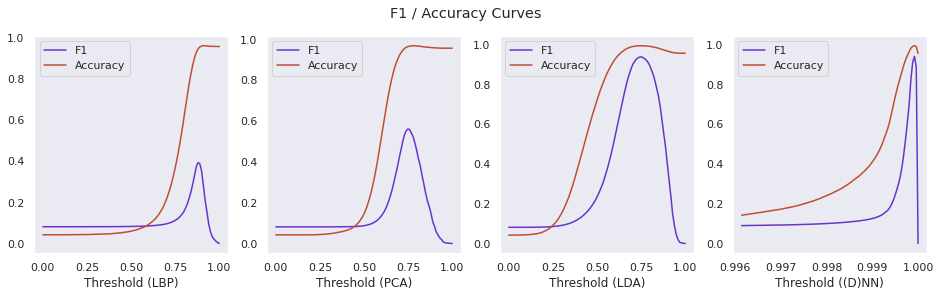

In [38]:
from sklearn.metrics import f1_score, fbeta_score, accuracy_score

center_plots()
figure, axes = plt.subplots(ncols=len(strategies), figsize=(16,4))
figure.suptitle('F1 / Accuracy Curves')

i = 0
beta = 3.0
for strategy in strategies:
  (genuine_id, distances, normalised, _) = scores_dict[strategy.name]
  # variable thresholds
  scores = 1 - normalised
  min_t = 0.0 if strategy.name != "(D)NN" else sorted(scores)[len(scores)-len(scores)//10*9] # outliers ...
  thresholds = np.linspace(min_t, 1.0, 100).tolist()
  #thresholds = sorted(scores[genuine_id > 0])
  f1_scores = [f1_score(genuine_id, np.where(scores >= t, 1, 0), average='binary') for t in thresholds]
  fbeta_scores = [fbeta_score(genuine_id, np.where(scores >= t, 1, 0), beta) for t in thresholds]
  accuracy_scores = [accuracy_score(genuine_id, np.where(scores >= t, 1, 0)) for t in thresholds]
  # visualise
  axes[i].plot(thresholds, f1_scores, color=(0.4,0.2,0.8), label='F1')
  axes[i].plot(thresholds, accuracy_scores, color=(0.75,0.3,0.2), label='Accuracy')
  axes[i].set(xlabel='Threshold (' + strategy.name + ')')
  axes[i].legend()
  i = i + 1
  # maximum F1
  imposters = scores[genuine_id < 1]
  genuine = scores[genuine_id > 0]
  max_f1_t = thresholds[f1_scores.index(max(f1_scores))]
  max_fbeta_t = thresholds[fbeta_scores.index(max(fbeta_scores))]
  print('Max F1 score at threshold = %f (' % max_f1_t + strategy.name + ').')
  print('Accuracy at this threshold = %f.' % accuracy_score(genuine_id, np.where(scores >= max_f1_t, 1, 0)))
  print('FPR at this threshold = %f.' % (len(imposters[imposters >= max_f1_t]) / float(len(imposters))))
  print('FRR at this threshold = %f.' % (len(genuine[genuine < max_f1_t]) / float(len(genuine))))
  print('Max Fß score at threshold = %f (' % max_fbeta_t + strategy.name + ').')
  print('Accuracy at this threshold = %f.' % accuracy_score(genuine_id, np.where(scores >= max_fbeta_t, 1, 0)))
  print('FPR at this threshold = %f.' % (len(imposters[imposters >= max_fbeta_t]) / float(len(imposters))))
  print('FRR at this threshold = %f.' % (len(genuine[genuine < max_fbeta_t]) / float(len(genuine))))
  print('---')

plt.show()

*There's not really an optimal threshold in the general sense as it depends on the data that's being used, as well as the use case; is the system used for a high-security application or maybe a commercial one?*

*Maximising the F1 score can be tricky as in some cases it may lead to unexpected outcomes as discussed [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4442797/) where it was shown that for some more extreme classifiers (e.g. an uninformative classifier with calibrated probabilities) the threshold that maximises F1 is 0.0 (it predicts everything as positive).*

*This shouldn't be a problem here. From the visuals it can be seen that the optimal thresholds are meaningful. An alternative is to weigh precision and recall differently (the so-called Fß score with ß a weighing parameter). Emphasizing recall more makes the FRR go down while it is rather high otherwise.*

*Some people recommend using proper scores like the Brier score, here I quickly consider a score that appears to be lesser known, called the Matthews correlation coefficient.*

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Max correlation coefficient at threshold = 0.888889 (LBP).
Accuracy at this threshold = 0.954696.
FPR at this threshold = 0.017767.
FRR at this threshold = 0.662688.
---
Max correlation coefficient at threshold = 0.757576 (PCA).
Accuracy at this threshold = 0.967362.
FPR at this threshold = 0.011161.
FRR at this threshold = 0.514147.
---
Max correlation coefficient at threshold = 0.747475 (LDA).
Accuracy at this threshold = 0.994828.
FPR at this threshold = 0.002189.
FRR at this threshold = 0.072060.
---
Max correlation coefficient at threshold = 0.999922 ((D)NN).
Accuracy at this threshold = 0.995224.
FPR at this threshold = 0.000651.
FRR at this threshold = 0.097259.
---


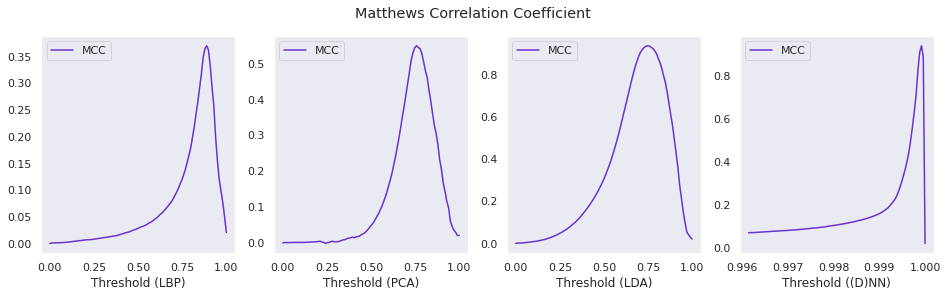

In [40]:
from sklearn.metrics import matthews_corrcoef

center_plots()
figure, axes = plt.subplots(ncols=len(strategies), figsize=(16,4))
figure.suptitle('Matthews Correlation Coefficient')

i = 0
beta = 3.0
for strategy in strategies:
  (genuine_id, distances, normalised, _) = scores_dict[strategy.name]
  # variable thresholds
  scores = 1 - normalised
  min_t = 0.0 if strategy.name != "(D)NN" else sorted(scores)[len(scores)-len(scores)//10*9] # outliers ...
  thresholds = np.linspace(min_t, 1.0, 100).tolist()
  # thresholds = sorted(scores[genuine_id > 0])
  coeffs = [matthews_corrcoef(genuine_id, np.where(scores >= t, 1, 0)) for t in thresholds]
  axes[i].plot(thresholds, coeffs, color=(0.4,0.2,0.8), label='MCC')
  axes[i].set(xlabel='Threshold (' + strategy.name + ')')
  axes[i].legend()
  i = i + 1
  # maximum F1
  imposters = scores[genuine_id < 1]
  genuine = scores[genuine_id > 0]
  max_cc_t = thresholds[coeffs.index(max(coeffs))]
  print('Max correlation coefficient at threshold = %f (' % max_cc_t + strategy.name + ').')
  print('Accuracy at this threshold = %f.' % accuracy_score(genuine_id, np.where(scores >= max_cc_t, 1, 0)))
  print('FPR at this threshold = %f.' % (len(imposters[imposters >= max_cc_t]) / float(len(imposters))))
  print('FRR at this threshold = %f.' % (len(genuine[genuine < max_cc_t]) / float(len(genuine))))
  print('---')

plt.show()

*The MCC should be an appropriate way to compare classifiers and is different from the F1 score in that it considers true negatives as well.*

*My preferred approach, however, would be to plot the ROC curve and find some operating point based on the desired maximal FAR. This was also recommended by Jain in his handbook on fingerprint recognition and to me it seems most appropriate as it takes the context into account.*

#### Task 3: Plot genuine and impostor scores

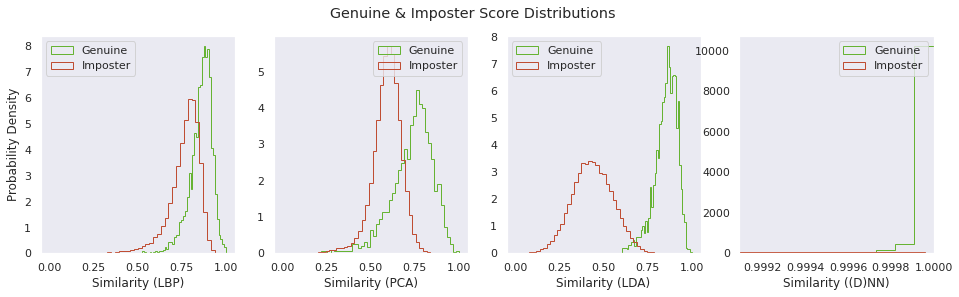

In [41]:
center_plots()
kwargs = dict(histtype='step', density=True, bins=45) # bins=45
figure, axes = plt.subplots(ncols=len(strategies), figsize=(16,4))
figure.suptitle('Genuine & Imposter Score Distributions')
i = 0
for strategy in strategies:
  (genuine_id, _, normalised, _) = scores_dict[strategy.name]
  scores = 1 - normalised
  axes[i].hist(scores[genuine_id > 0], color=(0.4,0.7,0.2), label='Genuine', **kwargs)
  axes[i].hist(scores[genuine_id < 1], color=(0.75,0.3,0.2), label='Imposter', **kwargs)
  if i == 0:
    axes[i].set(ylabel='Probability Density')
  axes[i].set(xlabel='Similarity (' + strategy.name + ')')
  if strategy.name == "(D)NN": # outliers ...
    axes[i].set(xlim=[sorted(scores)[len(scores)-len(scores)//10*6], 1.0])
  axes[i].legend()
  i = i + 1
plt.show()

*Two things to note :*

*(1) LDA nicely separates the distributions, more so than PCA does. This is normal. LDA is supervised and its goal is to maximise interclass variation and minimise intraclass variation. PCA just tries to capture variance but may capture irrelevant information by doing so (including lighting).*

*(2) The (D)NN has some very large outliers (when it comes to the distances for some of its imposter pairs) such that it becomes difficult to display a meaningful plot. This problem of visualisation and direct comparison with the other strategies is seen in other graphs such as the F1 plots. In some cases I consider only part of its outputs to compensate for the outliers. In other cases I manually checked the F1 plot over small intervals.*

#### Task 4: Calculate Equal Error Rate

EER (LBP) =  0.2432315185455406  at threshold =  0.8254068231606831
ROC AUC (LBP) =  0.8345419429457597
Threshold where weighted sum FPR+FNR is minimal :  0.895156
FPR at this threshold = 0.011772.
FRR at this threshold = 0.706012.
---
EER (PCA) =  0.20921657168773292  at threshold =  0.6529063889971052
ROC AUC (PCA) =  0.8565239612393405
Threshold where weighted sum FPR+FNR is minimal :  0.752711
FPR at this threshold = 0.013014.
FRR at this threshold = 0.494253.
---
EER (LDA) =  0.01867371285469209  at threshold =  0.6723212042234746
ROC AUC (LDA) =  0.9987860291727151
Threshold where weighted sum FPR+FNR is minimal :  0.736285
FPR at this threshold = 0.002997.
FRR at this threshold = 0.059682.
---
EER ((D)NN) =  0.03409382209689823  at threshold =  0.9998079906045524
ROC AUC ((D)NN) =  0.9909484648122022
Threshold where weighted sum FPR+FNR is minimal :  0.999907
FPR at this threshold = 0.001499.
FRR at this threshold = 0.076923.
---


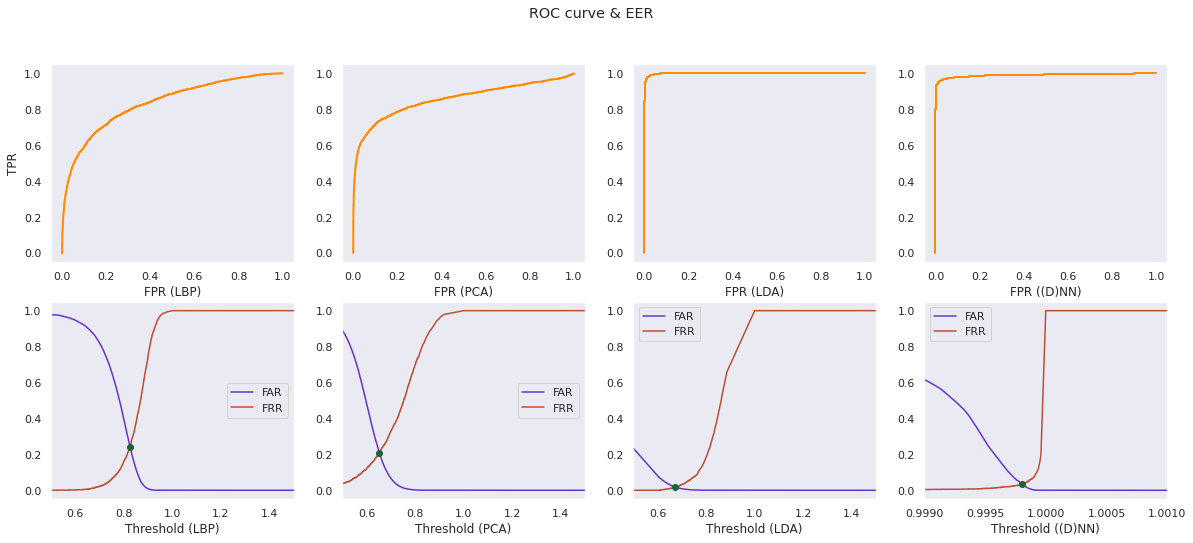

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score

def min_sum(tpr, fpr, thresholds, alpha=0.1, beta=0.9):
    return thresholds[np.argmax(alpha*tpr - beta*fpr)]

center_plots()
figure, axes = plt.subplots(ncols=len(strategies), nrows=2, figsize=(20,8))
figure.suptitle('ROC curve & EER')

i = 0
for strategy in strategies:
  (genuine_id, _, normalised, _) = scores_dict[strategy.name]
  fpr, tpr, thresholds = roc_curve(genuine_id, 1 - normalised)
  axes[0][i].plot(fpr, tpr, color='darkorange', lw=2)
  if i == 0:
    axes[0][i].set(ylabel='TPR')
  axes[0][i].set(xlabel='FPR (' + strategy.name + ')')
  # EER
  differences = [abs((1-x)-y) for (x,y) in zip(tpr, fpr)]
  min_index = differences.index(min(differences))
  print('EER (' + strategy.name + ') = ', fpr[min_index], ' at threshold = ', thresholds[min_index])
  print('ROC AUC (' + strategy.name + ') = ', roc_auc_score(genuine_id, 1 - normalised))
  # Minimum error sum
  scores = 1 - normalised
  imposters = scores[genuine_id < 1]
  genuine = scores[genuine_id > 0]
  sum_min_t = min_sum(tpr, fpr, thresholds)
  print('Threshold where weighted sum FPR+FNR is minimal : % f' % sum_min_t)
  print("FPR at this threshold = %f." % (len(imposters[imposters >= sum_min_t]) / float(len(imposters))))
  print("FRR at this threshold = %f." % (len(genuine[genuine < sum_min_t]) / float(len(genuine))))
  print('---')
  axes[1][i].scatter(thresholds[min_index], fpr[min_index], color=(0.1,0.4,0.2), zorder=3)
  axes[1][i].plot(thresholds, fpr, color=(0.4,0.2,0.8), label='FAR')
  axes[1][i].plot(thresholds, 1 - tpr, color=(0.75,0.3,0.2), label='FRR')
  axes[1][i].set(xlabel='Threshold (' + strategy.name + ')')
  axes[1][i].set(xlim=([0.999,1.001] if strategy.name == '(D)NN' else [0.5,1.5]))
  axes[1][i].legend()
  i = i + 1
  
plt.show()

*I also output the thresholds where the sum of FNR and FPR is minimal, with weights given to each. Weirdly enough the siamese network seems to do worse, than LDA. But for very small FPR rates it does better.*

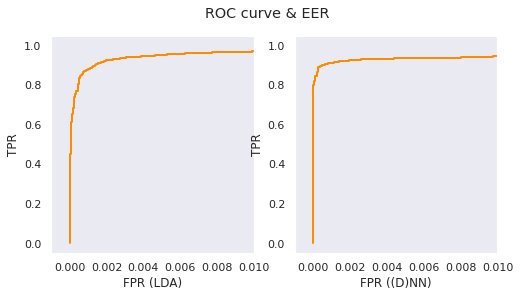

In [67]:
center_plots()
figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
figure.suptitle('ROC curve & EER')
for (strategy,i) in zip(strategies[2:],range(2)):
  (genuine_id, _, normalised, _) = scores_dict[strategy.name]
  fpr, tpr, thresholds = roc_curve(genuine_id, 1 - normalised)
  axes[i].plot(fpr, tpr, color='darkorange', lw=2)
  axes[i].set(ylabel='TPR')
  axes[i].set(xlabel='FPR (' + strategy.name + ')', xlim=[-0.001,0.01])

#### Task 5: Calculate classification scores (PR curve, AUC, Average Precision)

AUC (LBP) =  0.359961
AP (LBP) =  0.023524
AUC (PCA) =  0.560832
AP (PCA) =  0.023808
AUC (LDA) =  0.980113
AP (LDA) =  0.021672
AUC ((D)NN) =  0.965368
AP ((D)NN) =  0.021676


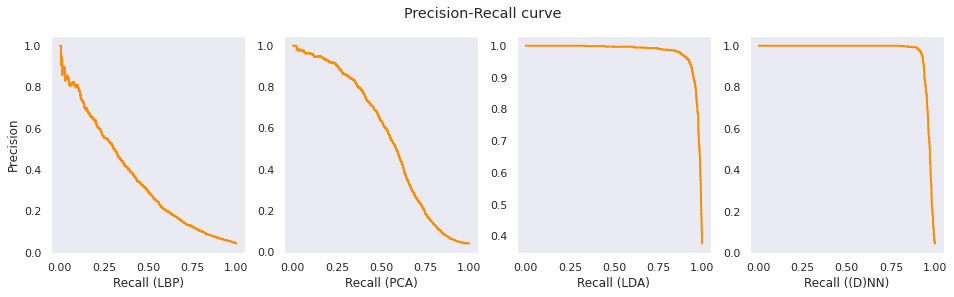

In [68]:
# Calculate PR curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

center_plots()
figure, axes = plt.subplots(ncols=len(strategies), figsize=(16,4))
figure.suptitle('Precision-Recall curve')

i = 0
for strategy in strategies:
  (genuine_id, _, normalised, _) = scores_dict[strategy.name]
  precision, recall, _ = precision_recall_curve(genuine_id, 1 - normalised)
  axes[i].plot(recall, precision, color='darkorange', lw=2)
  if i == 0:
    axes[i].set(ylabel='Precision')
  axes[i].set(xlabel='Recall (' + strategy.name + ')')
  i = i + 1
  print('AUC (' + strategy.name + ') = % f' % auc(recall, precision))
  print('AP (' + strategy.name + ') = % f' % average_precision_score(genuine_id, normalised))

## 6.2 Validation as identification system

#### Task 6: Generate a Cumulative Matching Curve

*I read [The FERET evaluation methodlogy for face-recognition algorithms](https://www.jordaanelectronics.com/pdfonline/face%20recognition/feret_methodology_nist_ir_6264.pdf)) where ROC and CMC curves are used, but in this setting a multi-gallery-shot setting has to be dealt with, just like in the fingerprint recognition task. It was proposed to either use a random sample as a gallery image or to aggregate scores on a tensor where all samples of each individual pair is compared in the z-axis. The former is not reproducable but should give a good idea of the performance. The latter is optimistic for aggregate functions like mean and maximum (maybe even for minimum).*

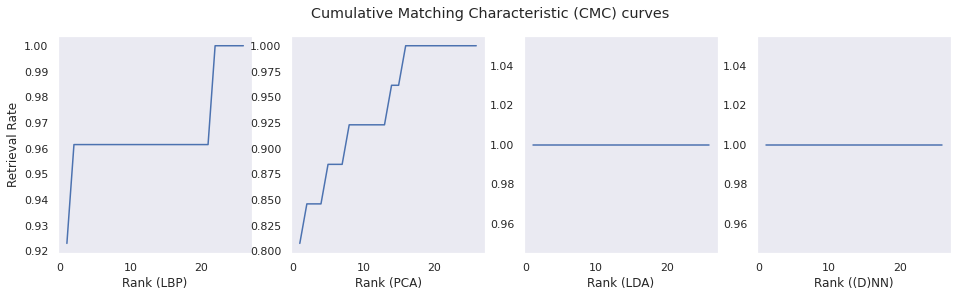

In [69]:
def CMC(similarity_matrix, n_ranks=8):
  """Calculate the Cumulative Matching Characteristic (CMC) curve."""
  cmc = [0] * n_ranks
  for (i,row) in enumerate(similarity_matrix):
    rank = len(row) - 1 - np.argsort(np.argsort(row))[i]
    if rank < n_ranks:
      cmc[rank] += 1
    prev = 0
  for i in range(n_ranks):
    prev = cmc[i] + prev
    cmc[i] = prev / similarity_matrix.shape[0]
  return cmc

center_plots()
figure, axes = plt.subplots(ncols=len(strategies), figsize=(16,4))
figure.suptitle('Cumulative Matching Characteristic (CMC) curves')

i = 0
for strategy in strategies:
  (_, _, _, matrix) = scores_dict[strategy.name]
  cmc = CMC(matrix, n_ranks=26)
  axes[i].plot(list(range(1, len(cmc) + 1)), cmc)
  if i == 0:
    axes[i].set(ylabel='Retrieval Rate')
  axes[i].set(xlabel='Rank (' + strategy.name + ')')
  i = i + 1

plt.show()

*It's quite clear that LDA or the siamese network perform best. As in previous assignments ensembles are always possible, also. I try the randomised CMC curve next because I expect it to give a more meaningful picture.*

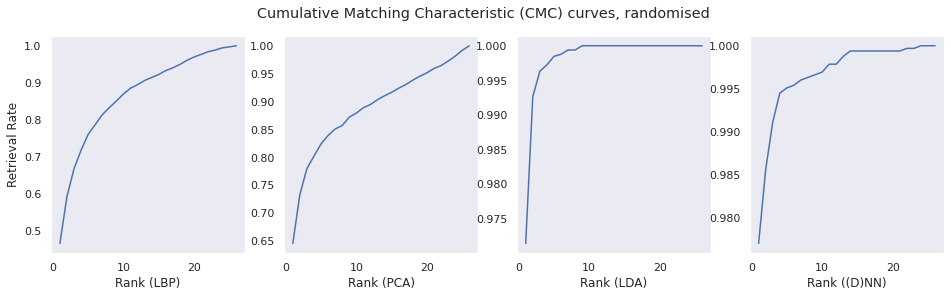

In [90]:
import random
def random_CMC(strategy, n_ranks=26, training=True):
    """CMC curve calculation with random galleries."""
    embeddings = strategy.describe(strategy.x_train) if strategy.embeddings is None else strategy.embeddings
    embeddings_test = strategy.embeddings if training == True else strategy.describe(strategy.x_test)
    input_labels = strategy.y_train if training == True else strategy.y_test
    uniques = list(set(strategy.y_train))
    gallery_elements = [[i for i in range(len(strategy.y_train)) if strategy.y_train[i] == l] for l in uniques]
    cmc = [0] * n_ranks
    for (i,e) in zip(range(len(embeddings_test)),embeddings_test):
      label_idx = input_labels[i]
      gallery = [random.choice(els) for els in gallery_elements]
      if training == True:
        while gallery[label_idx] == i:
          gallery[label_idx] = random.choice(gallery_elements[label_idx])
      distances = [strategy.distance(e,embeddings[x]) for x in gallery]
      rank = np.argsort(np.argsort(distances))[label_idx] # it's distances now, not similarities!
      if rank < n_ranks:
        cmc[rank] += 1
    return np.cumsum(cmc) / len(embeddings_test)


# Visualise
N = 10
considered_strategies = strategies#[2:]
center_plots()
figure, axes = plt.subplots(ncols=len(considered_strategies), figsize=(16,4))
figure.suptitle('Cumulative Matching Characteristic (CMC) curves, randomised')
for (i,strategy) in zip(range(len(considered_strategies)),considered_strategies):
  cmc = random_CMC(strategy, n_ranks=26)
  cmc = np.mean([random_CMC(strategy, n_ranks=26) for j in range(N)], axis=0)
  axes[i].plot(list(range(1, len(cmc) + 1)), cmc)
  if i == 0:
    axes[i].set(ylabel='Retrieval Rate')
  axes[i].set(xlabel='Rank (' + strategy.name + ')')
plt.show()

*It does, and the parameter N (number of times to repeat the experiment) makes the curve more smooth.*

## 6.2 Validation in multi-classification setting

#### Task 7: Validate the advanced classification scenario

*Until now the binary (genuine versus imposter scores) setting was evaluated. To evaluate a multi-class classifier the micro F1 score can be used where an unweighted average is taken.*


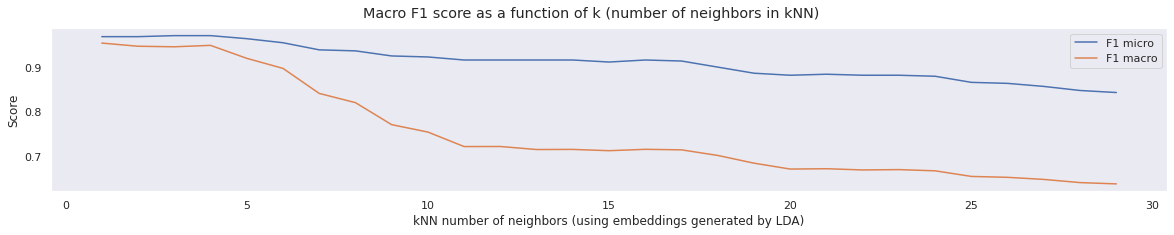

In [103]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

def get_nn_scores(strategy, metric='f1_micro', test_values=list(range(1,30))):
  embeddings = strategy.describe(np.vstack((strategy.x_train, strategy.x_test)))
  targets = np.hstack((strategy.y_train,strategy.y_test))
  nn_scores = []
  for nb_neighbors in test_values:
    knn = KNeighborsClassifier(n_neighbors=nb_neighbors, metric='euclidean')
    scores = cross_val_score(knn, embeddings, targets, cv=2, scoring=metric)
    nn_scores.append(sum(scores) / len(scores))
  return nn_scores

# Visualise
strategy = strategies[2]
center_plots()
figure, axes = plt.subplots(figsize=(20,3))
figure.suptitle('Macro F1 score as a function of k (number of neighbors in kNN)')
axes.plot(test_values, get_nn_scores(strategy), label='F1 micro')
axes.plot(test_values, get_nn_scores(strategy, metric='f1_macro'), label='F1 macro')
axes.set(ylabel='Score')
axes.set(xlabel='kNN number of neighbors (using embeddings generated by ' + strategy.name + ')')
axes.legend()
plt.show()

*The question whether to take micro - or macro-average depends on what you want ; is a majority class more important to classify than minority classes? Note that I used cross-validation to get an estimate of the metric.*

## 7. Task
All tasks should be accompanied by a text providing information on; the technique, the steps, and, the reasoning behind choosing the techniques.

### 7.1. Mandatory tasks

Compare the 4 feature representations (LBP, PCA, LDA, DL using Siamese Networks) using the implemented validation metrics and report on the performance below (you can for instance store your intermediary results/plots in a file and plot them below).

EER (LBP) =  0.21313791276708458  at threshold =  0.8103179541738086
ROC AUC (LBP) =  0.8629123513579218
AUC (LBP) =  0.389216
AP (LBP) =  0.020474
EER (PCA) =  0.18665018541409148  at threshold =  0.5457039436592759
ROC AUC (PCA) =  0.8832180252745973
AUC (PCA) =  0.578164
AP (PCA) =  0.020173
EER (LDA) =  0.05050326681970687  at threshold =  0.6656919765721279
ROC AUC (LDA) =  0.9923894305653328
AUC (LDA) =  0.938765
AP (LDA) =  0.019283
EER ((D)NN) =  0.08493731237859792  at threshold =  0.9948903871030189
ROC AUC ((D)NN) =  0.9727671320957613
AUC ((D)NN) =  0.871090
AP ((D)NN) =  0.019335


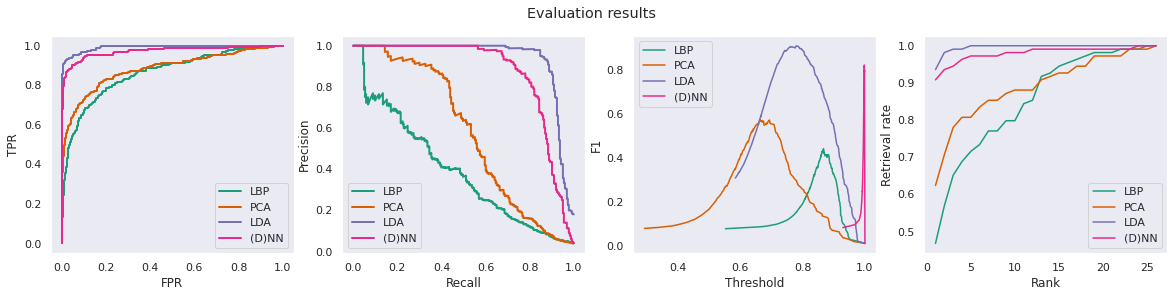

In [106]:
def evaluate(strategies, scores):
  """
  Evaluate different strategies.
  This prints ROC, PR, F1 and CMC curves.
  @param strategies The used models.
  @param scores The scores outputted by the models.
  """
  # prepare plots
  center_plots()
  figure, axes = plt.subplots(ncols=4, figsize=(20,4))
  figure.suptitle('Evaluation results')
  axes[0].set(ylabel='TPR', xlabel='FPR')
  axes[1].set(ylabel='Precision', xlabel='Recall')
  axes[2].set(ylabel='F1', xlabel='Threshold')
  axes[3].set(ylabel='Retrieval rate', xlabel='Rank')
  color_idx = 0
  colors = plt.get_cmap("Dark2").colors
  for (strategy, strategy_scores) in zip(strategies, scores):
    (genuine_id_test, _, normalised_test, matrix_test) = strategy_scores
    # ROC
    fpr, tpr, thresholds = roc_curve(genuine_id_test, 1 - normalised_test)
    axes[0].plot(fpr, tpr, color=colors[color_idx], lw=2, label=strategy.name)
    differences = [abs((1-x)-y) for (x,y) in zip(tpr, fpr)]
    min_index = differences.index(min(differences))
    print('EER (' + strategy.name + ') = ', fpr[min_index], ' at threshold = ', thresholds[min_index])
    print('ROC AUC (' + strategy.name + ') = ', roc_auc_score(genuine_id_test, 1 - normalised_test))
    # Precision-Recall
    precision, recall, _ = precision_recall_curve(genuine_id_test, 1 - normalised_test)
    axes[1].plot(recall, precision, color=colors[color_idx], lw=2, label=strategy.name)
    print('AUC (' + strategy.name + ') = % f' % auc(recall, precision))
    print('AP (' + strategy.name + ') = % f' % average_precision_score(genuine_id_test, normalised_test))
    # F1
    scores = 1 - normalised_test
    thresholds = sorted(scores[genuine_id_test > 0]) #np.linspace(0.0, 1.0, 100).tolist()
    f1_scores = [f1_score(genuine_id_test, np.where(scores >= t, 1, 0)) for t in thresholds]
    axes[2].plot(thresholds, f1_scores, color=colors[color_idx], label=strategy.name)
    # CMC
    cmc = random_CMC(strategy, training=False)
    axes[3].plot(list(range(1, len(cmc) + 1)), cmc, color=colors[color_idx], label=strategy.name)
    # Next color
    color_idx = color_idx + 1
  axes[0].legend()
  axes[1].legend()
  axes[2].legend()
  axes[3].legend()
  plt.show()

evaluate(strategies, [scores_test_dict[strategy.name] for strategy in strategies])

*LDA performs better than (D)NN which performs better than PCA which performs better than LBP. These results remain the same even when tuning the parameters a lot, except for the (D)NN which can outperform the LDA strategy.*  

### 7.2. Tasks of choice
<b>The student should choose a number of tasks equivalent to <u>at least 3pts</u> from the list below (pts are not related to the grades)</b>. 

1. Evaluate your system on the other two datasets (AT&T, LFW) (1pt.)
2. Implement 2 different face detectors and compare all techniques to the to the ground truth bounding boxes provided in <em>CalTechFacesDirs/ImageData.mat</em>. (1pt.)
3. Develop a new advanced classifier (beyond KNN) and compare the results with the current KNN classifier. (1pt.)
4. Experiment with the Siamese deep learning model by implementing a different loss function or a different distance calculation layer. (1pt.)
5. Pre-train your deep learning network on a different (larger) dataset and compare the results. (1pt.) 
6. Implement a different deep learning model* (2pt.)

#### Subtask 1 : evaluate your system on the other two datasets


In [ ]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.datasets import fetch_lfw_people

olivetti = fetch_olivetti_faces()
lfw = fetch_lfw_people(min_faces_per_person=4) # minimum number of faces per person for stratification

EER (LBP) =  0.18767967145790554  at threshold =  0.8609922911220212
ROC AUC (LBP) =  0.8536755646817248
AUC (LBP) =  0.490348
AP (LBP) =  0.008975
EER (PCA) =  0.20390143737166325  at threshold =  0.488554742663564
ROC AUC (PCA) =  0.8857186858316222
AUC (PCA) =  0.506491
AP (PCA) =  0.008585
EER (LDA) =  0.09876796714579056  at threshold =  0.6262935285249438
ROC AUC (LDA) =  0.9700539014373717
AUC (LDA) =  0.758253
AP (LDA) =  0.008265
EER ((D)NN) =  0.23470225872689937  at threshold =  0.9966552439016968
ROC AUC ((D)NN) =  0.8509060574948665
AUC ((D)NN) =  0.215565
AP ((D)NN) =  0.008889


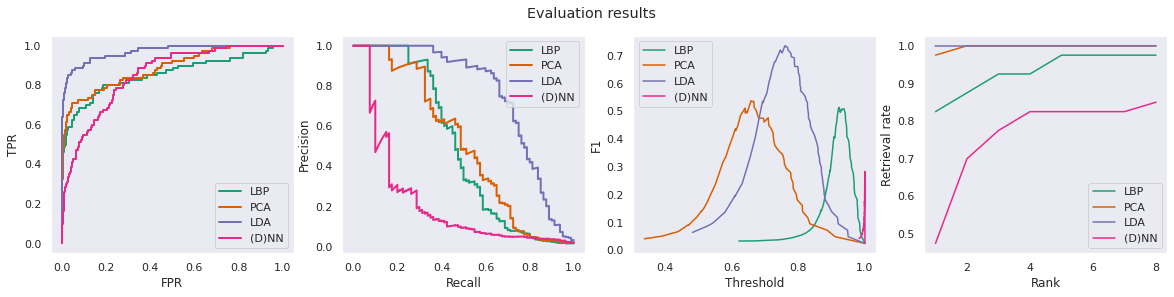

In [ ]:
import os.path
from localmodules import siamese

for (dataset, name) in zip([olivetti], ['olivetti']):
  scores_file = './scores/scores_' + name + '.p'
  if os.path.isfile(scores_file): # load database scores from disk
    pickle_file = open(scores_file, "rb")
    scores = pickle.load(pickle_file)
  else: # compute scores from scratch
    strategies = []
    for strategy_class in strategy_classes:
      strategy = strategy_class(dataset)
      strategy.fit()
      strategies.append(strategy)
    scores = [strategy.get_scores_test() for strategy in strategies]
    pickle_file = open(scores_file, "wb")
    pickle.dump(scores, pickle_file)
  evaluate(strategies, scores)

*The LFW dataset is much larger.*

In [ ]:
print('Size of LFW = ', lfw.data.shape)

Size of LFW =  (6733, 2914)


50/50 - 30s - loss: 0.1045 - accuracy: 0.6619 - val_loss: 0.2452 - val_accuracy: 0.0433


EER (LBP) =  0.45862283599360876  at threshold =  0.7727906268191416
ROC AUC (LBP) =  0.5621368164185574
AUC (LBP) =  0.015078
AP (LBP) =  0.008699


KeyboardInterrupt: ignored

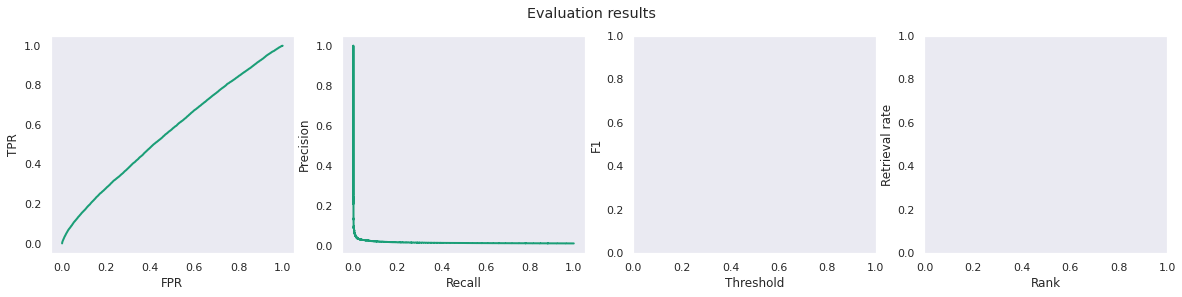

In [58]:
for (dataset, name) in zip([lfw], ['lfw']):
  scores_file = './scores/scores_' + name + '.p'
  if os.path.isfile(scores_file): # load database scores from disk
    pickle_file = open(scores_file, "rb")
    scores = pickle.load(pickle_file)
  else: # compute scores from scratch
    strategies = []
    for strategy_class in strategy_classes:
      strategy = strategy_class(dataset)
      strategy.fit()
      strategies.append(strategy)
    scores = [strategy.get_scores_test() for strategy in strategies]
    pickle_file = open(scores_file, "wb")
    pickle.dump(scores, pickle_file)
  evaluate(strategies, scores)

#### Subtask 2 : implement 2 different face detectors

*First, I experiment with skin texture detection and compare it with the bounding boxes. Next, I use a neural network from Keras.*

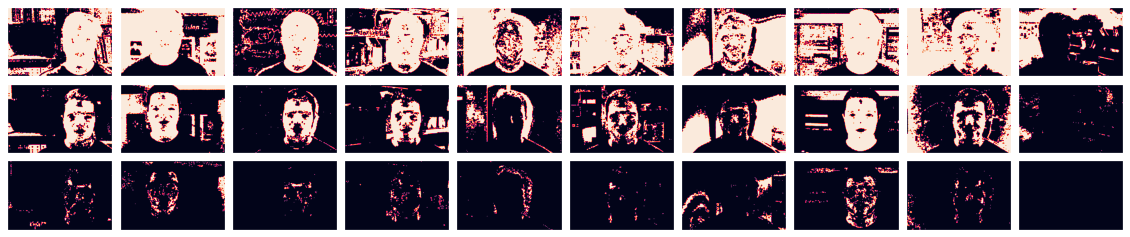

In [ ]:
# Skin detection approach
from scripts import skin_detector

class FaceDetectionTexture(FaceDetectionStrategy):
  """A class for detecting faces using skin detection."""
  def __init__(self):
    super().__init__("Skin detection")
  def detect(self, image, minsize):
    mask = skin_detector.process(image, thresh=0.9)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour, max_area = None, 0
    minx, miny, maxx, maxy = 0, 0, 0, 0
    for i in range(len(contours)):
      contour = contours[i]
      (x, y, width, height) = cv2.boundingRect(contour)
      minx, miny, maxx, maxy = min(minx,x), min(miny,y), max(maxx,x+width), max(maxy,y+height)
      if width * height > max_area:
        largest_contour = (x, y, width, height)
    return [largest_contour] if largest_contour is not None else [] # can also use combined contour

# Detect faces and visualise results
detection_strategy = FaceDetectionTexture()
#faces_skin = detection_strategy.detect_multi(data_color['images'][1:10], data_color['target'][1:10], paths=imagePaths[1:10])
center_plots()
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 10), axes_pad=0.1)
i = 0
for ax, im in zip(grid, data_color['images'][1:11]*3):
    i += 1
    ax.imshow(skin_detector.process(im, thresh=0.3*(i//10)+0.3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

*Every row depicts results for a given threshold (which increases towards the bottom). Immediately it becomes apparent that the skin texture detection isn't doing well. If I'd take the largest contour in the mask the results are pretty much worthless. In the sixth image, the lighting has made the algorithm fail to detect the actual skin. At best, the skin texture information may help discriminate between face and non-face parts of the images, complementing some other detection algorithm.*

Using TensorFlow backend.


     |████████████████████████████████| 2.3MB 2.8MB/s 


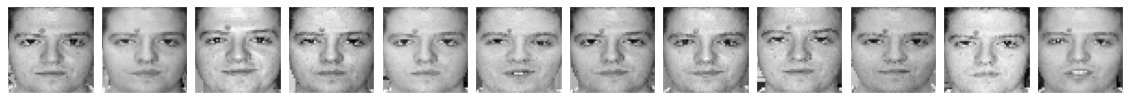

In [ ]:
# Face detection with neural network
class FaceDetectionNeural(FaceDetectionStrategy):
  """A class for detecting faces using skin detection."""
  def __init__(self):
    super().__init__("Skin detection")
    import keras
    try:
      from mtcnn.mtcnn import MTCNN # https://arxiv.org/abs/1604.02878
    except ImportError:
      !pip install mtcnn
      from mtcnn.mtcnn import MTCNN
    self.detector = MTCNN()
  def detect(self, image, minsize):
    return [face['box'] for face in self.detector.detect_faces(image)]

# Detect faces and save to disk
detection_strategy = FaceDetectionNeural()
faces_nn_path = './pickle/caltech_faces_neural.p'
if os.path.isfile(faces_nn_path):
  saved_pickle_file = open(faces_nn_path, 'rb')
  faces_nn = pickle.load(saved_pickle_file)
else:
  faces_nn = detection_strategy.detect_multi(data_color['images'], data_color['target'], paths=imagePaths)
  tosave_pickle_file = open(faces_nn_path, 'wb')
  pickle.dump(faces_nn, tosave_pickle_file)

# Detect faces and visualise results
center_plots()
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 12), axes_pad=0.1)
for ax, im in zip(grid, faces_nn['images']):
    ax.imshow(cv2.cvtColor(np.reshape(im,(face_size[0],face_size[1],3)), cv2.COLOR_BGR2GRAY), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

*First note : the images were no face were detected are hard (one where the person covers his face, one with dark lighting). Now to compare them with the given bounding boxes...*

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


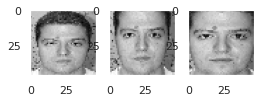

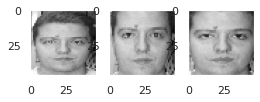

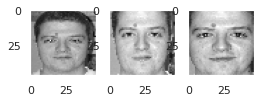

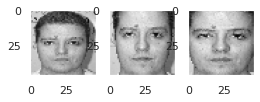

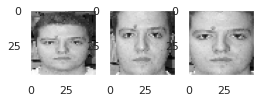

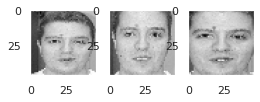

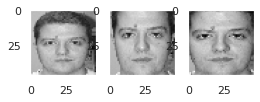

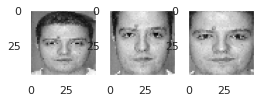

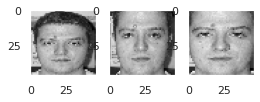

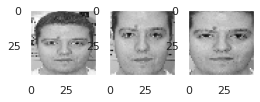

Mean IoU =  0.6595616217530232
Mean IoU =  0.6120770849904349


In [ ]:
def extract_faces(considered_models, original_idx):
  """Extract faces from the image at given index based on the given considered models."""
  extracted_faces, extracted_masks = [], []
  for faces_bunch in considered_models:
    possible_idx = np.argwhere(faces_bunch.original_indices == original_idx)
    idx = possible_idx[0][0] if possible_idx.shape[0] > 0 else -1
    if idx >=0:
      (x,y,w,h) = faces_bunch.boxes[idx]
      mask = np.zeros(img_shape, np.uint8)
      mask[y:y+h,x:x+w] = 1
      extracted_faces.append(cv2.resize(image.copy()[y:y+h, x:x+w], face_size))
      extracted_masks.append(mask)
    else:
      extracted_faces.append(np.asarray([]))
      extracted_masks.append(np.asarray([]))
  return extracted_faces, extracted_masks

def get_ground_truth(idx):
  """Get the ground truth mask and face image."""
  ends = ground_truth[0:8,idx]
  (x,y,w,h) = (int(ends[0]),int(ends[3]),int(abs(ends[4]-ends[0])), int(abs(ends[3]-ends[1])))
  mask_truth = np.zeros(img_shape, np.uint8)
  mask_truth[y:y+h,x:x+w] = 1
  face_truth = cv2.resize(image.copy()[y:y+h, x:x+w], face_size)
  return mask_truth, face_truth

# Compare with bounding boxes in mat file
import scipy.io
mat = scipy.io.loadmat('CalTechFacesDirs/ImageData.mat')
ground_truth = mat['SubDir_Data']
#print(mat['SubDir_Data'].shape)
#print(mat['SubDir_Data'][7])

# Calculate mIOU
center_plots()
from sklearn.metrics import jaccard_similarity_score
import re
img_shape = data['images'][0].shape[:2]
ious = []
stems_idx = [int(re.findall('\d*\.?\d+', p.stem)[0]) for p in imagePaths]
cap = 10
considered_models = [faces, faces_nn]
for original_idx in range(len(data['images'])):
  image = data['images'][original_idx]
  # get extracted faces from models
  extracted_faces, extracted_masks = extract_faces(considered_models, original_idx)
  # get ground truth extracted face
  mask_truth, face_truth = get_ground_truth(stems_idx[original_idx]-1)
  # iou
  ious.append([jaccard_similarity_score(mask, mask_truth) if mask.shape[0] > 0 else 0 for mask in extracted_masks])
  # visualise
  if original_idx < cap:
    fig, ax = plt.subplots(nrows=1, ncols=1+len(considered_models), figsize=(4,4))
    ax[0].imshow(face_truth, cmap='gray')
    for i in range(len(extracted_faces)):
      ax[1+i].imshow(extracted_faces[i], cmap='gray')
    plt.show()
for mIoU in np.mean(ious, axis=0):
  print('Mean IoU = ', mIoU)

*This may seem like a weak mean IoU score, except that the bounding boxes that were given do not extract faces, they extract the heads, rather. Despite the fact that the IoUs were larger for the Viola-Jones detection I think this is simply related to the fact that it takes more of the head into account. I'd still say the neural network outpeforms it since it only failed to detect the face in two cases, 8 less than the Viola-Jones detector. Besides, focusing on the face itself makes it easier to find meaningful features.*

[0, 1]


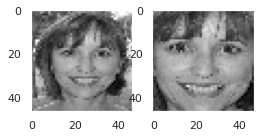

[0, 1]


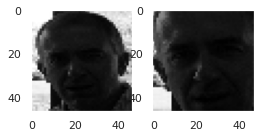

[0, 1]


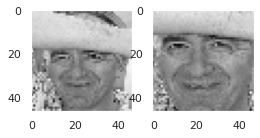

[0, 0]


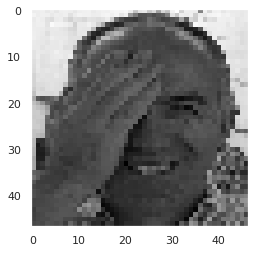

[0, 1]


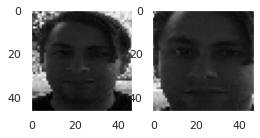

[0, 1]


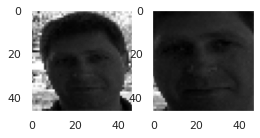

[0, 0]


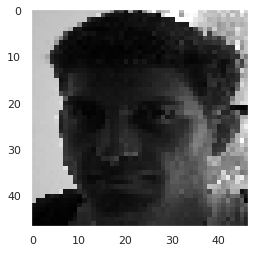

[0, 1]


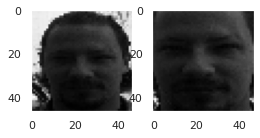

[0, 1]


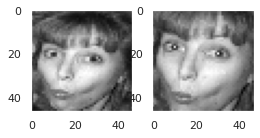

[0, 1]


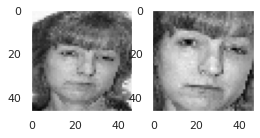

In [ ]:
# Test out some of the harder faces
center_plots()
for original_idx in range(len(data['images'])):
  image = data['images'][original_idx]
  extracted_faces, extracted_masks = extract_faces(considered_models, original_idx)
  valid_faces = [1 if face.shape[0] > 0 else 0 for face in extracted_faces]
  if sum(valid_faces) < len(considered_models):
    print(valid_faces)
    fig, ax = plt.subplots(nrows=1, ncols=1+sum(valid_faces), figsize=(4,4))
    _, face_truth = get_ground_truth(stems_idx[original_idx]-1)
    if sum(valid_faces) < 1:
      ax.imshow(face_truth, cmap='gray')
    else:
      x = 0
      ax[0].imshow(face_truth, cmap='gray')
      for i in np.argwhere(np.asarray(valid_faces) > 0):
        ax[1+x].imshow(extracted_faces[i[0]], cmap='gray')
        x += 1
    plt.show()

*So while the neural network focuses more on the face itself (which sometimes distorts it more when resizing it) it does detect better than the Viola-Jones detector. Clearly lighting and facial expressions are the cause of failures in the case of Viola-Jones, and in some cases both detectors failed (2 in total, one in which the man covers his face)*

#### Subtask 3 : develop a new advanced classifier (beyond KNN)

In [ ]:
# So do SVM here to try and get better than KNN

#### Subtask 4 : experiment with the Siamese deep learning model

#### Subtask 6 : implement a different deep learning model